In [24]:
from UNet import *

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [6]:
ds = xr.open_dataset('ERA5_Data\WindComponents_16_48.nc')
ds.load()

ds['ws'] = (ds.u10**2 + ds.v10**2)**0.5



In [7]:
window_size = 3
variable = 'ws'

X, y = [], []

for i in range(ds.time.size - window_size):
    X.append(ds[variable].isel(time=slice(i, i + window_size)))
    y.append(ds[variable].isel(time=i + window_size))

X_ = np.array(X) 
y_ = np.array(y)

# Train Validation Split
split = round(X_.shape[0] * 0.9)

# Shape fixing
lon_shape = ds.longitude.size
lat_shape = ds.latitude.size

# Custom Shapes for the data
# lon_shape = 64
# lat_shape = 32
# X_ = X_[:,:, 1:33, 3:67]
# y_ = y_[:,1:33,3:67]

# Normalization
max_ws = X_.max()
X_n = X_ / max_ws
y_n = y_ / max_ws

# Splitting
f_train, t_train = X_n[:split].astype('float32'), y_n[:split].astype('float32')
f_test, t_test = X_n[split:].astype('float32'), y_n[split:].astype('float32')
print('Train Shape: ', f_train.shape, t_train.shape, '\n\nTest Shape: ', f_test.shape, t_test.shape)

X_n = X_n.reshape(-1, lat_shape, lon_shape, window_size)
y_n = y_n.reshape(-1, lat_shape, lon_shape,  1)

f_training, t_training = X_n[:split].astype('float32'), y_n[:split].astype('float32')
f_testing, t_testing = X_n[split:].astype('float32'), y_n[split:].astype('float32')



Train Shape:  (625, 3, 16, 48) (625, 16, 48) 

Test Shape:  (69, 3, 16, 48) (69, 16, 48)


In [26]:
def build_RRnet(input_shape, steps = 1):
    inputs = Input(input_shape)

    s1, p1 = RR_encoder_block(inputs, 16)
    s2, p2 = RR_encoder_block(p1, 32)
    # s3, p3 = encoder_block(p2, 256)
    # s4, p4 = encoder_block(p3, 512)

    b1 = RR_block(p2, 64) #Bridge

    # d1 = decoder_block(b1, s4, 512)
    # d2 = decoder_block(d1, s3, 256)
    d3 = RR_decoder_block(b1, s2, 32)
    d4 = RR_decoder_block(d3, s1, 16)

    outputs = Conv2D(steps, 1, padding="same", activation="sigmoid")(d4)  #Binary (can be multiclass)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [27]:
input_shape = tuple((1, lat_shape, lon_shape, window_size))
plot_shape = t_training[0].shape

model = build_RRnet(input_shape[1:])

model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 16, 48, 3)]          0         []                            
                                                                                                  
 conv2d_187 (Conv2D)         (None, 16, 48, 16)           448       ['input_7[0][0]']             
                                                                                                  
 conv2d_188 (Conv2D)         (None, 16, 48, 16)           2320      ['conv2d_187[0][0]']          
                                                                                                  
 batch_normalization_156 (B  (None, 16, 48, 16)           64        ['conv2d_188[0][0]']          
 atchNormalization)                                                                           

In [32]:
batch_size = 64
epochs = 500
model.compile(optimizer='adam', loss='mse')

early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1, mode='min')
model_checkpoint = ModelCheckpoint('synth_RR.h5', monitor='val_loss', save_best_only=True, verbose=1, mode='min')

if True:
    history = model.fit(
        f_training,
        t_training,
        batch_size=batch_size,
        epochs=epochs,
        verbose=1,
        validation_data=(f_testing, t_testing),
        callbacks=[early_stopping, model_checkpoint]
    )

Epoch 1/500
10/10 [==============================] - ETA: 0s - loss: 0.0134
Epoch 1: val_loss improved from inf to 0.02849, saving model to synth_RR.h5


c:\Users\23603526\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 15s 334ms/step - loss: 0.0134 - val_loss: 0.0285
Epoch 2/500
10/10 [==============================] - ETA: 0s - loss: 0.0062
Epoch 2: val_loss improved from 0.02849 to 0.02806, saving model to synth_RR.h5
10/10 [==============================] - 2s 248ms/step - loss: 0.0062 - val_loss: 0.0281
Epoch 3/500
10/10 [==============================] - ETA: 0s - loss: 0.0041
Epoch 3: val_loss improved from 0.02806 to 0.02514, saving model to synth_RR.h5
10/10 [==============================] - 3s 263ms/step - loss: 0.0041 - val_loss: 0.0251
Epoch 4/500
10/10 [==============================] - ETA: 0s - loss: 0.0034
Epoch 4: val_loss improved from 0.02514 to 0.02076, saving model to synth_RR.h5
10/10 [==============================] - 2s 244ms/step - loss: 0.0034 - val_loss: 0.0208
Epoch 5/500
 8/10 [=======================>......] - ETA: 0s - loss: 0.0031

KeyboardInterrupt: 

1/1 [==============================] - 0s 37ms/step


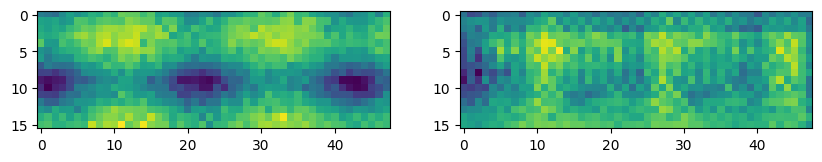

In [31]:
model.load_weights('synth_RR')

pred = model.predict(f_train[0:1].reshape(input_shape)).reshape(plot_shape).squeeze()

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(t_train[0].reshape(plot_shape).squeeze())
ax[1].imshow(pred)

plt.show()
